In [89]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#data handling
import pandas as pd
import numpy as np
import calendar
import datetime

#plotting
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

#time series analysis and modelling
from scipy.ndimage import gaussian_filter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from statsmodels.tsa.stattools import adfuller,kpss

# EDA

## Data Loading

In [90]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_store = pd.read_csv('data/store.csv')

In [91]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [92]:
# function to rename columns in lower case
def lower_case(dataframe):
    cols = dataframe.columns.tolist()
    cols = [col.lower() for col in cols]
    dataframe.columns = cols
    return dataframe

In [93]:
lower_case(df_train);
lower_case(df_store);
lower_case(df_test);

In [94]:
# function to change date into datetime
def to_datetime(dataframe):
    dataframe.assign(
        timestamp = lambda x: pd.to_datetime(x['date']),
        year = lambda x: x['timestamp'].dt.year,
        month = lambda x: x['timestamp'].dt.month,
        day = lambda x: x['timestamp'].dt.day,
        dayofyear = lambda x: x['timestamp'].dt.dayofyear)
    return dataframe
# does not work :( 

In [95]:
#df_train = to_datetime(df_train)

In [96]:
# changing date into datetime object, inserting year, month, day and dayofyear columns
df_train = df_train.assign(
            timestamp = lambda x: pd.to_datetime(x['date']),
            year = lambda x: x['timestamp'].dt.year,
            month = lambda x: x['timestamp'].dt.month,
            day = lambda x: x['timestamp'].dt.day,
            dayofyear = lambda x: x['timestamp'].dt.dayofyear)
df_train.drop("date", inplace=True, axis=1)

In [97]:
df_train.head()

,store,dayofweek,sales,customers,open,promo,stateholiday,schoolholiday,timestamp,year,month,day,dayofyear
0,1,5,5263,555,1,1,0,1,2015-07-31,2015,7,31,212
1,2,5,6064,625,1,1,0,1,2015-07-31,2015,7,31,212
2,3,5,8314,821,1,1,0,1,2015-07-31,2015,7,31,212
3,4,5,13995,1498,1,1,0,1,2015-07-31,2015,7,31,212
4,5,5,4822,559,1,1,0,1,2015-07-31,2015,7,31,212


In [98]:
print(df_store.shape)
df_store.head()

(1115, 10)


,store,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,promointerval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Data Cleaning

In [99]:
df_train.shape

(1017209, 13)

### Closed stores and zero sales stores

In [100]:
# closed stores
df_train[(df_train['open'] == 0) & (df_train['sales'] == 0)].shape

(172817, 13)

In [101]:
df_train[(df_train['open'] != 0) & (df_train['sales'] == 0)].shape

(54, 13)

There are 172817 stores, which were closed and had no sales. In addition to 54 open stores, which had no sales at that day.

We cannot make any predictions for stores, which were closed, and stores which were open, but had no sales, might have had external influences, such as remodeling.

To avoid any bias, we should drop these datapoints with 0 sales.

In [102]:
df_train = df_train[(df_train["open"] != 0) & (df_train['sales'] != 0)]
df_train.shape

(844338, 13)

In [103]:
df_train['stateholiday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [104]:
df_train.stateholiday.value_counts()

0    731308
0    112120
a       694
b       145
c        71
Name: stateholiday, dtype: int64

In [105]:
df_train['stateholiday'].replace({0:'0'}, inplace=True)
round(df_train.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
store,844338.0,558.42,321.73,1.0,280.0,558.0,837.0,1115.0
dayofweek,844338.0,3.52,1.72,1.0,2.0,3.0,5.0,7.0
sales,844338.0,6955.96,3103.82,46.0,4859.0,6369.0,8360.0,41551.0
customers,844338.0,762.78,401.19,8.0,519.0,676.0,893.0,7388.0
open,844338.0,1.00,0.00,1.0,1.0,1.0,1.0,1.0
promo,844338.0,0.45,0.50,0.0,0.0,0.0,1.0,1.0
schoolholiday,844338.0,0.19,0.40,0.0,0.0,0.0,0.0,1.0
year,844338.0,2013.83,0.78,2013.0,2013.0,2014.0,2014.0,2015.0
month,844338.0,5.85,3.32,1.0,3.0,6.0,8.0,12.0
day,844338.0,15.84,8.68,1.0,8.0,16.0,23.0,31.0


### Cleaning NaN's

In [106]:
df_store.isnull().sum()

store                          0
storetype                      0
assortment                     0
competitiondistance            3
competitionopensincemonth    354
competitionopensinceyear     354
promo2                         0
promo2sinceweek              544
promo2sinceyear              544
promointerval                544
dtype: int64

In [107]:
df_store[pd.isnull(df_store.competitiondistance)]

,store,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,promointerval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [108]:
# fill NaN with a median value
df_store['competitiondistance'].fillna(df_store['competitiondistance'].median(), inplace = True)
df_store['competitiondistance'].isnull().sum()

0

In [109]:
tmp = df_store[pd.isnull(df_store.competitionopensinceyear)]
tmp[tmp.competitiondistance != 0].shape

(354, 10)

Here these stores have a competition in their vicinity ('competitiondistance' =/= 0), but there is no information about the year this competition has been open. This value needs to be imputed in a meaningful way. Or just filled with '0'.

In [110]:
tmp = df_store[pd.isnull(df_store.promo2sinceweek)]
tmp[tmp.promo2 != 0].shape

(0, 10)

There are no stores with information about 'promo2sinceweek' which have 'NaN' in promo2.

In [111]:
# replace NA's by 0
df_store.fillna(0, inplace = True)

In [112]:
print(df_store.isnull().sum())
print('------------------------')
print(df_train.isnull().sum())

store                        0
storetype                    0
assortment                   0
competitiondistance          0
competitionopensincemonth    0
competitionopensinceyear     0
promo2                       0
promo2sinceweek              0
promo2sinceyear              0
promointerval                0
dtype: int64
------------------------
store            0
dayofweek        0
sales            0
customers        0
open             0
promo            0
stateholiday     0
schoolholiday    0
timestamp        0
year             0
month            0
day              0
dayofyear        0
dtype: int64


## Data Exploration

In [113]:
# Merge df_store and df_train
df = df_train.merge(df_store, how='left', left_on=df_train.store, right_on=df_store.store)
df.drop(['key_0', 'store_y'], axis=1, inplace=True)
df = df.rename(columns={'store_x':'store'})

In [114]:
df.groupby('storetype')['sales'].describe()

,count,mean,std,min,25%,50%,75%,max
storetype,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


In [115]:
df.groupby('storetype')['customers', 'sales'].sum()

,customers,sales
storetype,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


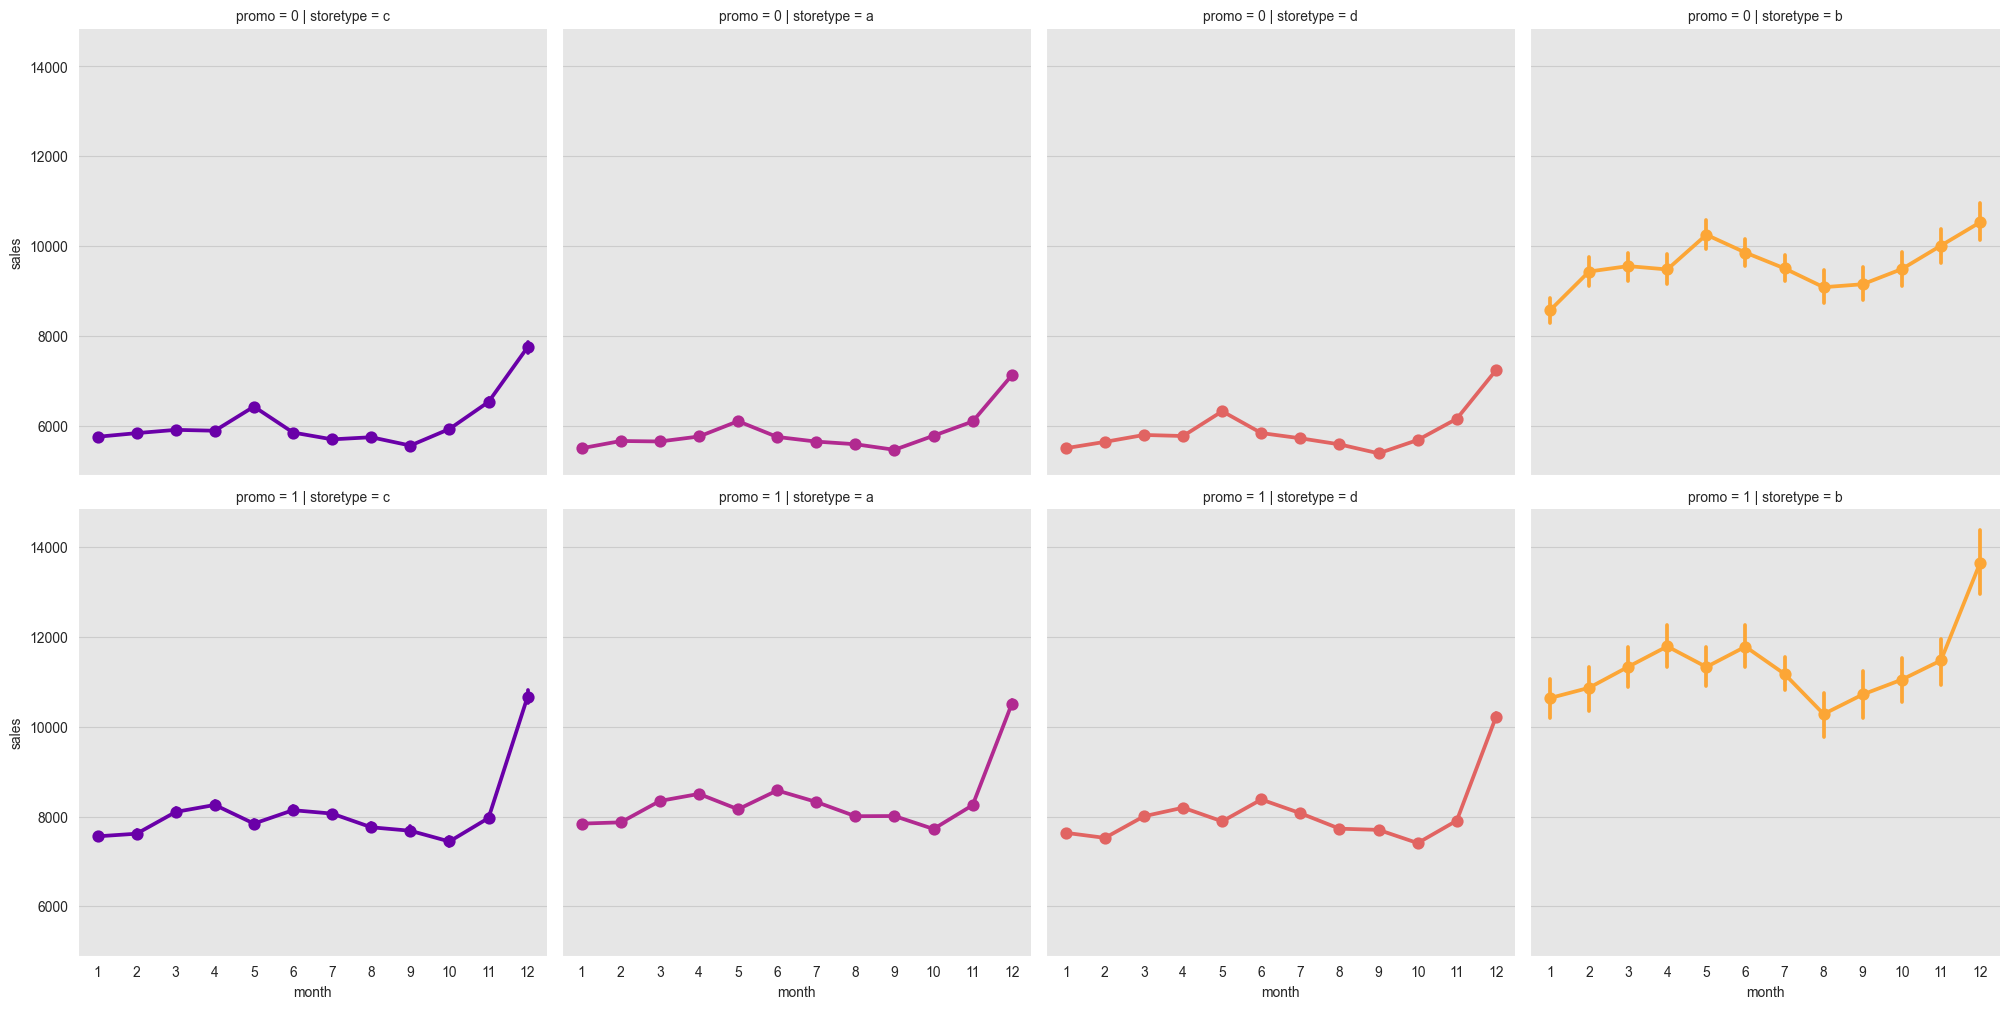

In [116]:
# sales trends
sns.factorplot(data = df, x = 'month', y = "sales", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo', 
               ) 

Storetype B has the highest sales numbers, with the largest variance. All storetypes show increased sales numbers towards christmas. 

Stores which have run a promo, show higher sales. But storetypes a,c and d show a dip towards easter, if they have run a promo, which is not the case for stores without a promo.

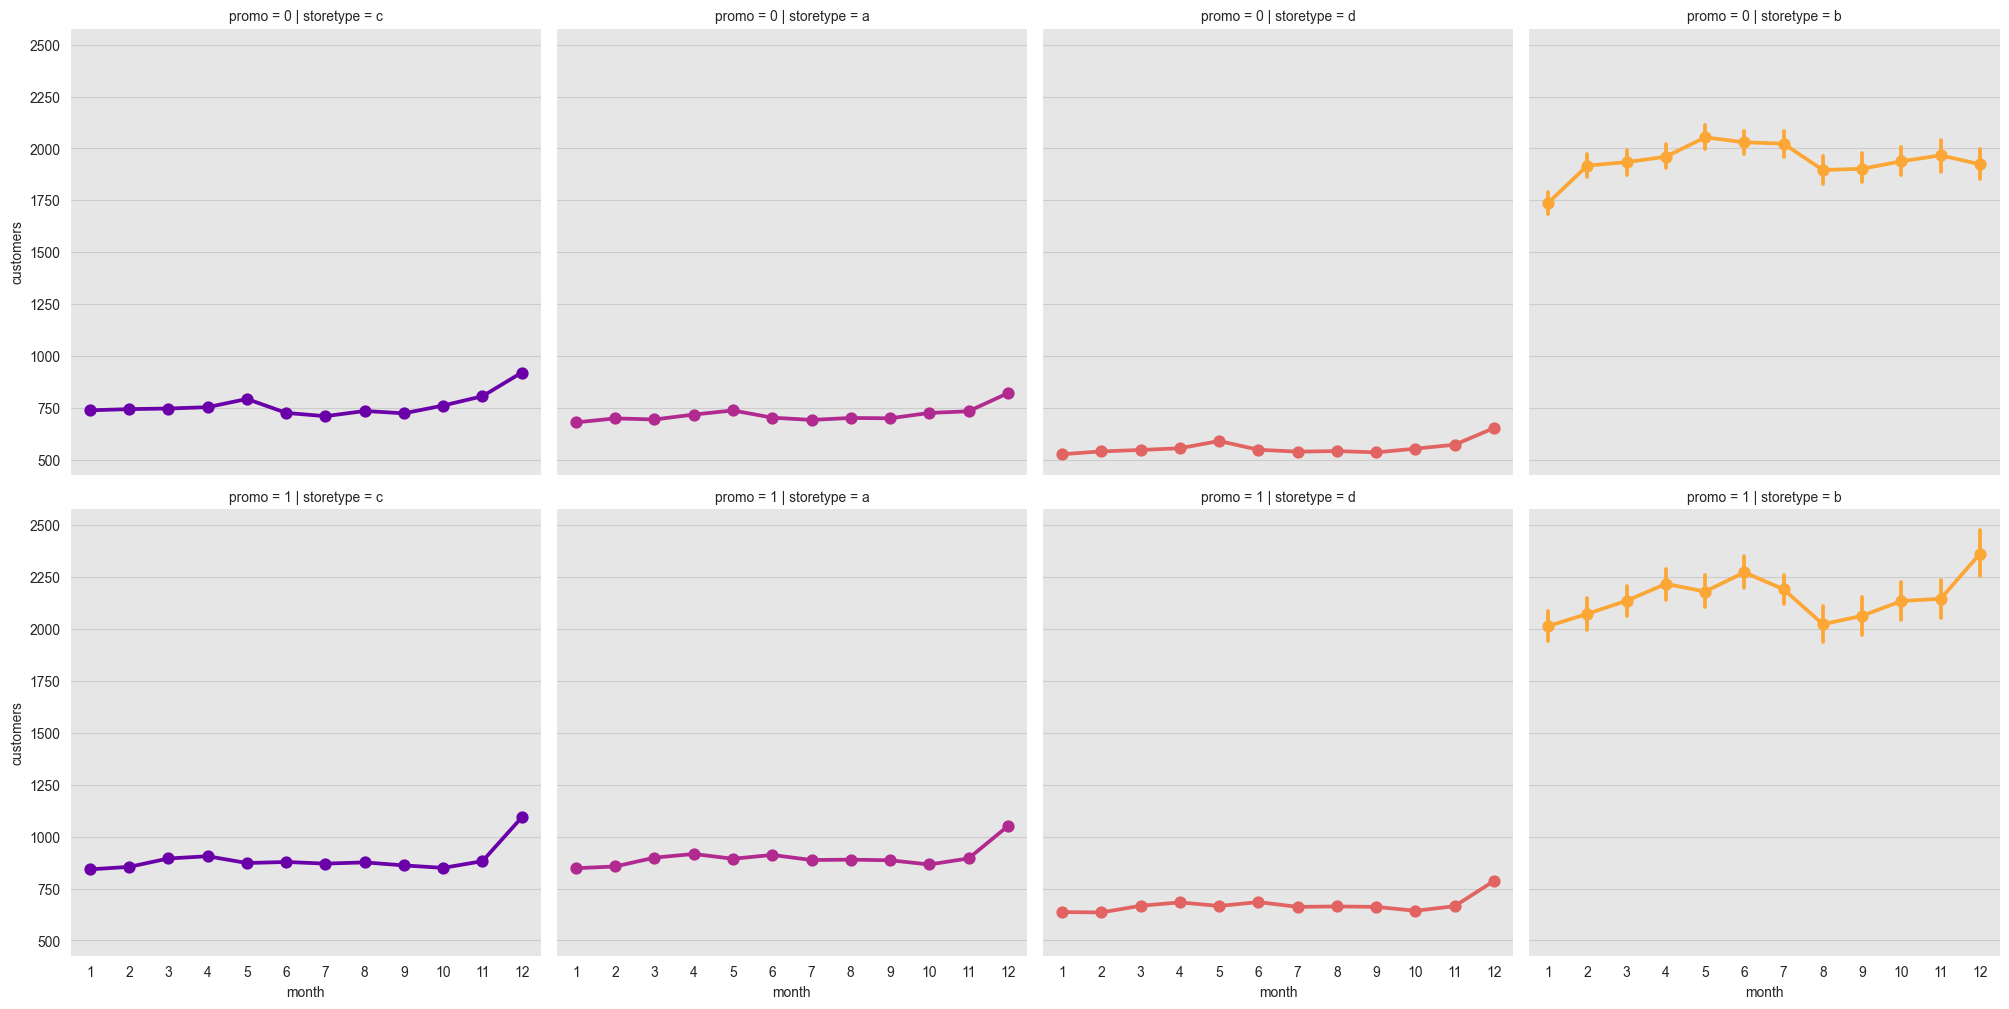

In [117]:
# customers trends
sns.factorplot(data = df, x = 'month', y = "customers", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo',
               ) 

Storetype B has the highest number of customers, with the largest variance. All storetypes show an increase of customers towards christmas. This trend is higher, if they have run a promo.

Same effect of a dip for storetypes a,c and d in customers towards easter can be also be seen here.

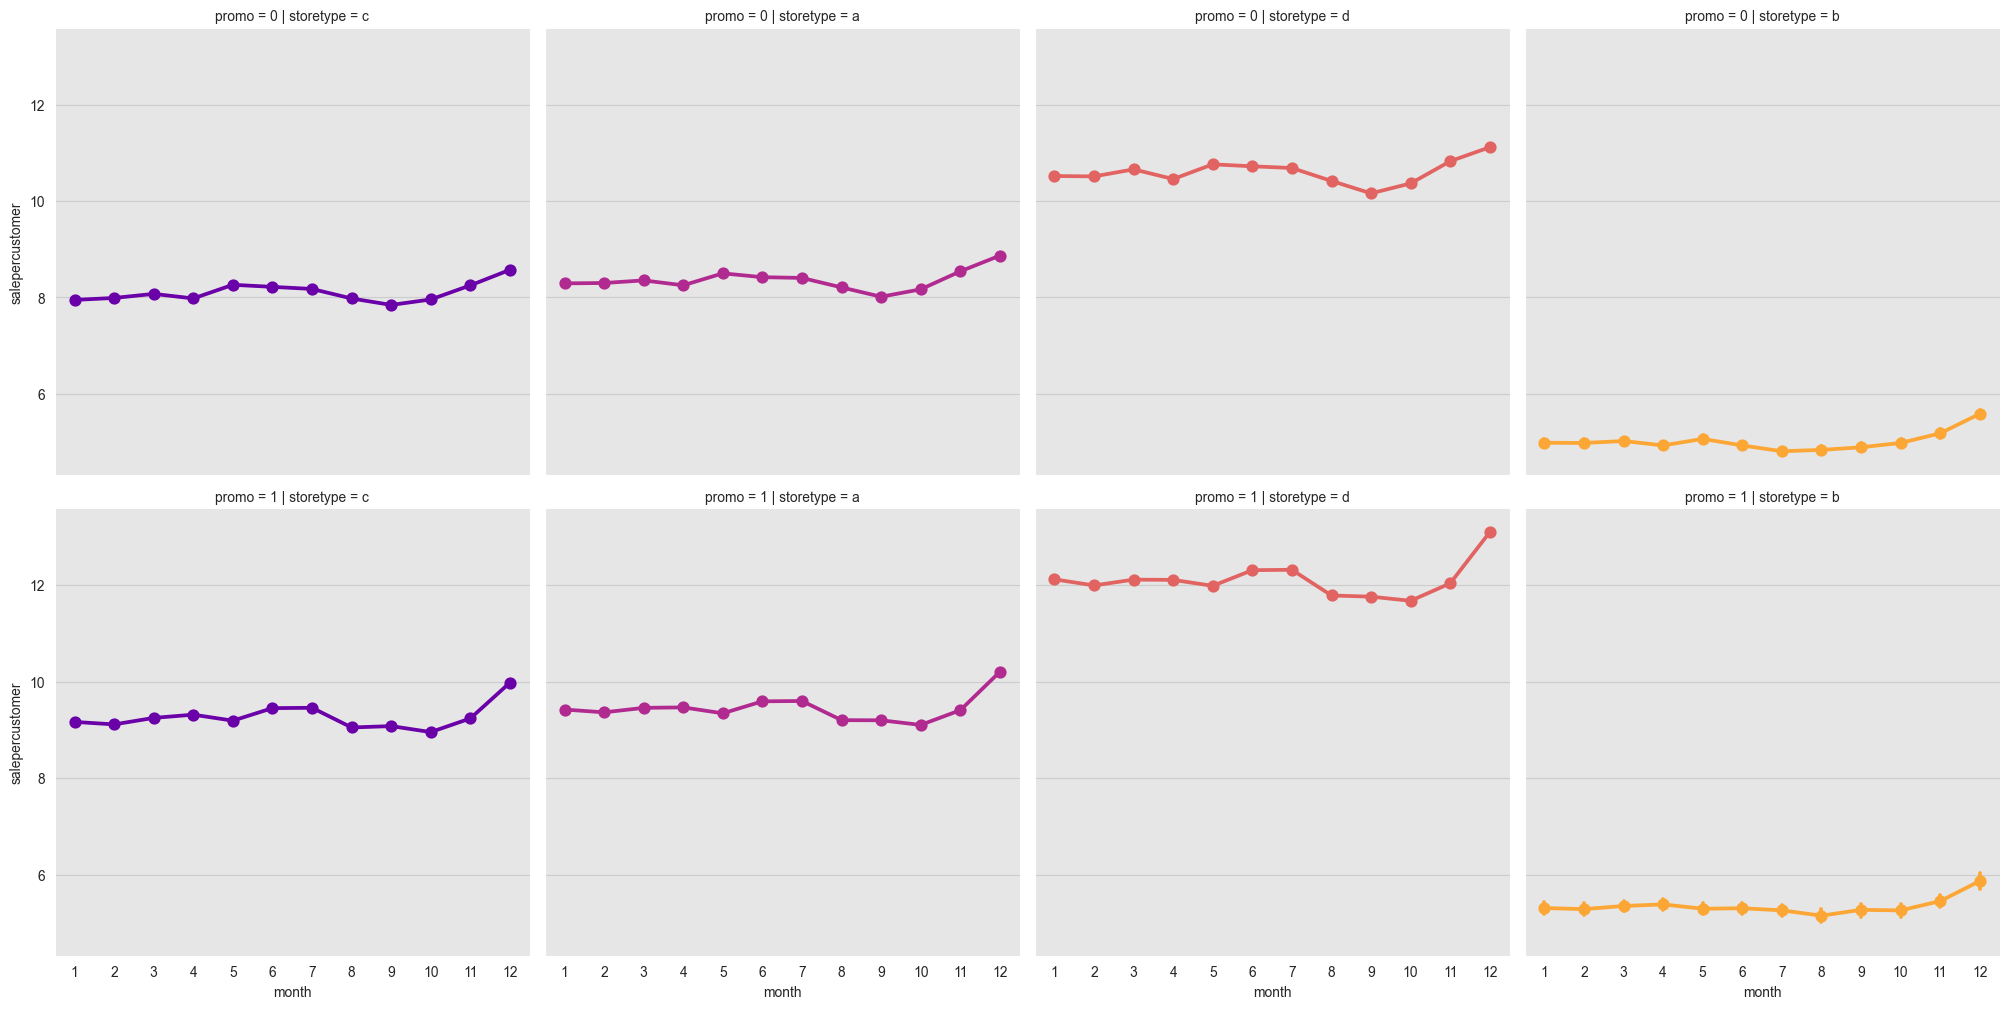

In [118]:
# sale per customer trends
df['salepercustomer'] = df['sales']/df['customers']
sns.factorplot(data = df, x = 'month', y = "salepercustomer", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo', 
               ) 

Sales per customer:
storetype b seems to be where customers only buy small items in low numbers (possible trainstation location?)
storetype d customers buy the largest quantity
a und c are very similar

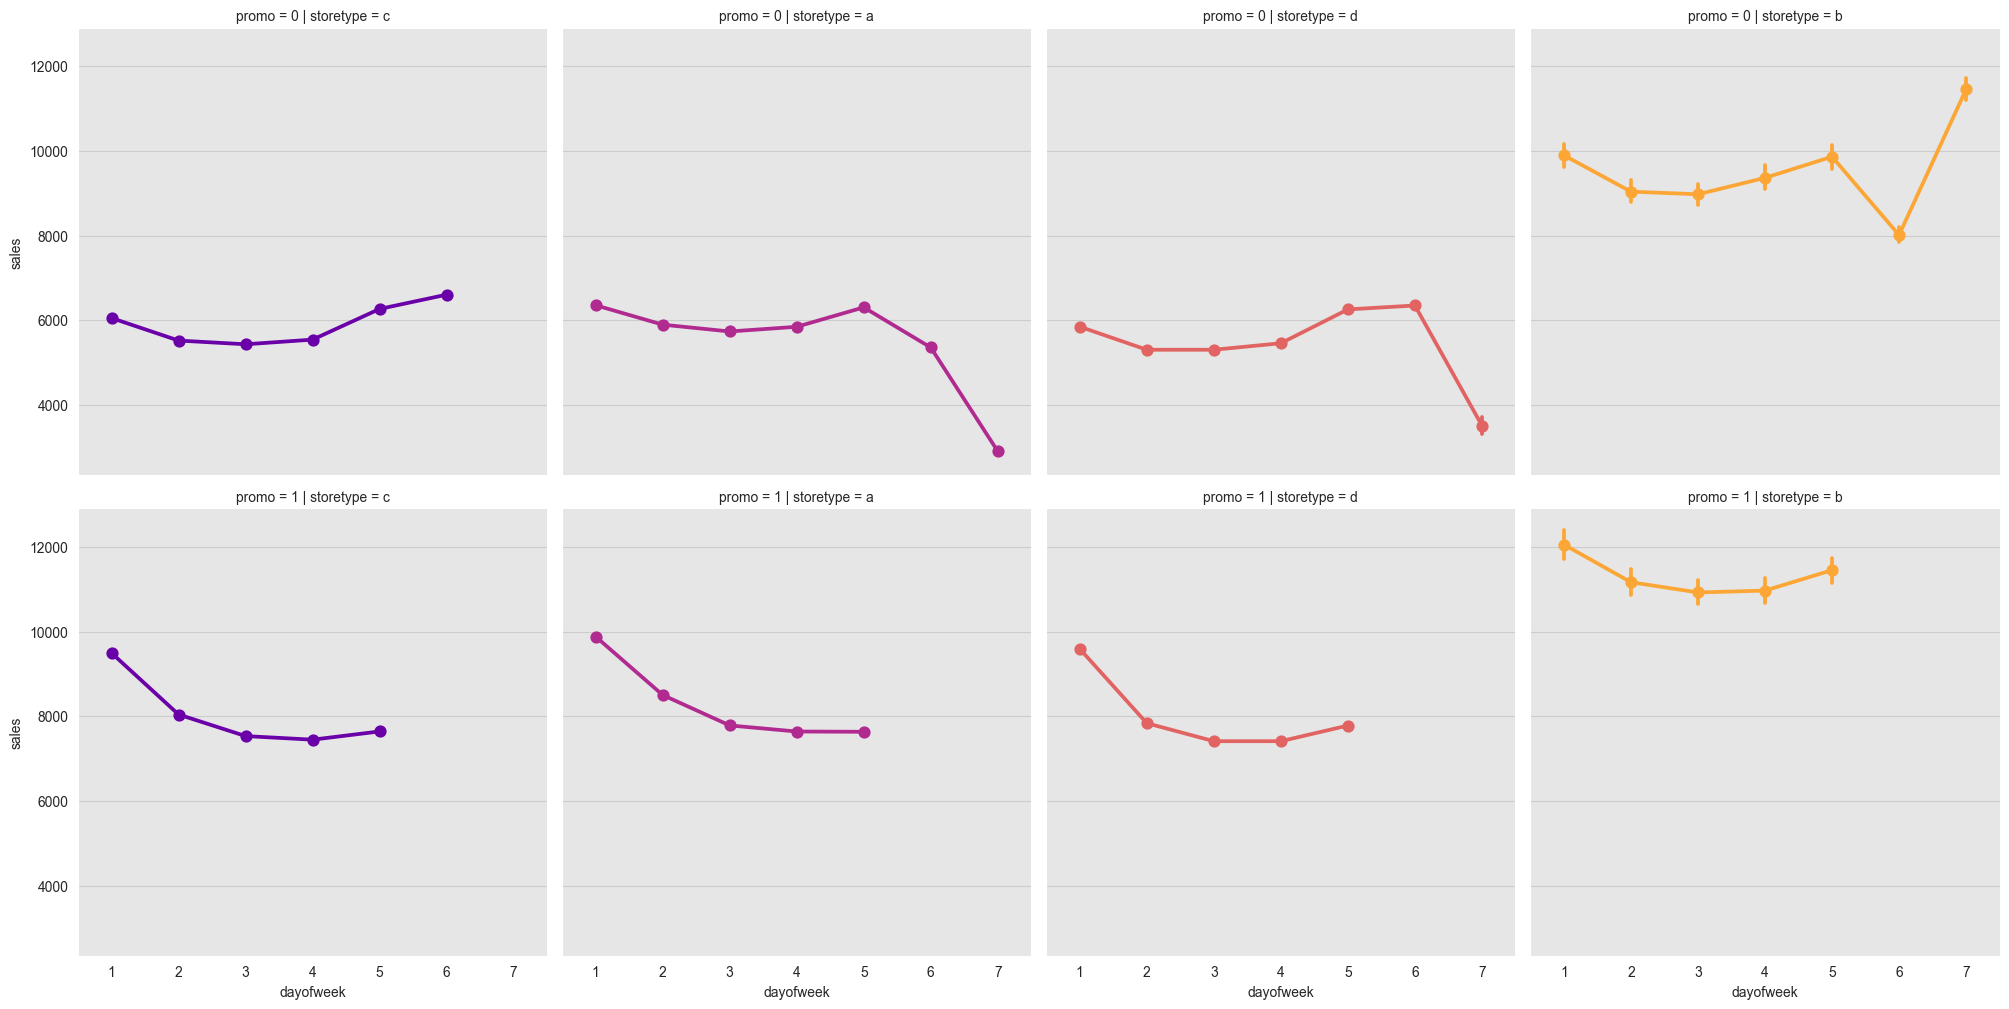

In [119]:
# weekday trends
sns.factorplot(data = df, x = 'dayofweek', y = "sales", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo',
               ) 

Similar trends regarding sales numbers and customers.
Highest number of sales and customers on mondays, if a promo was run

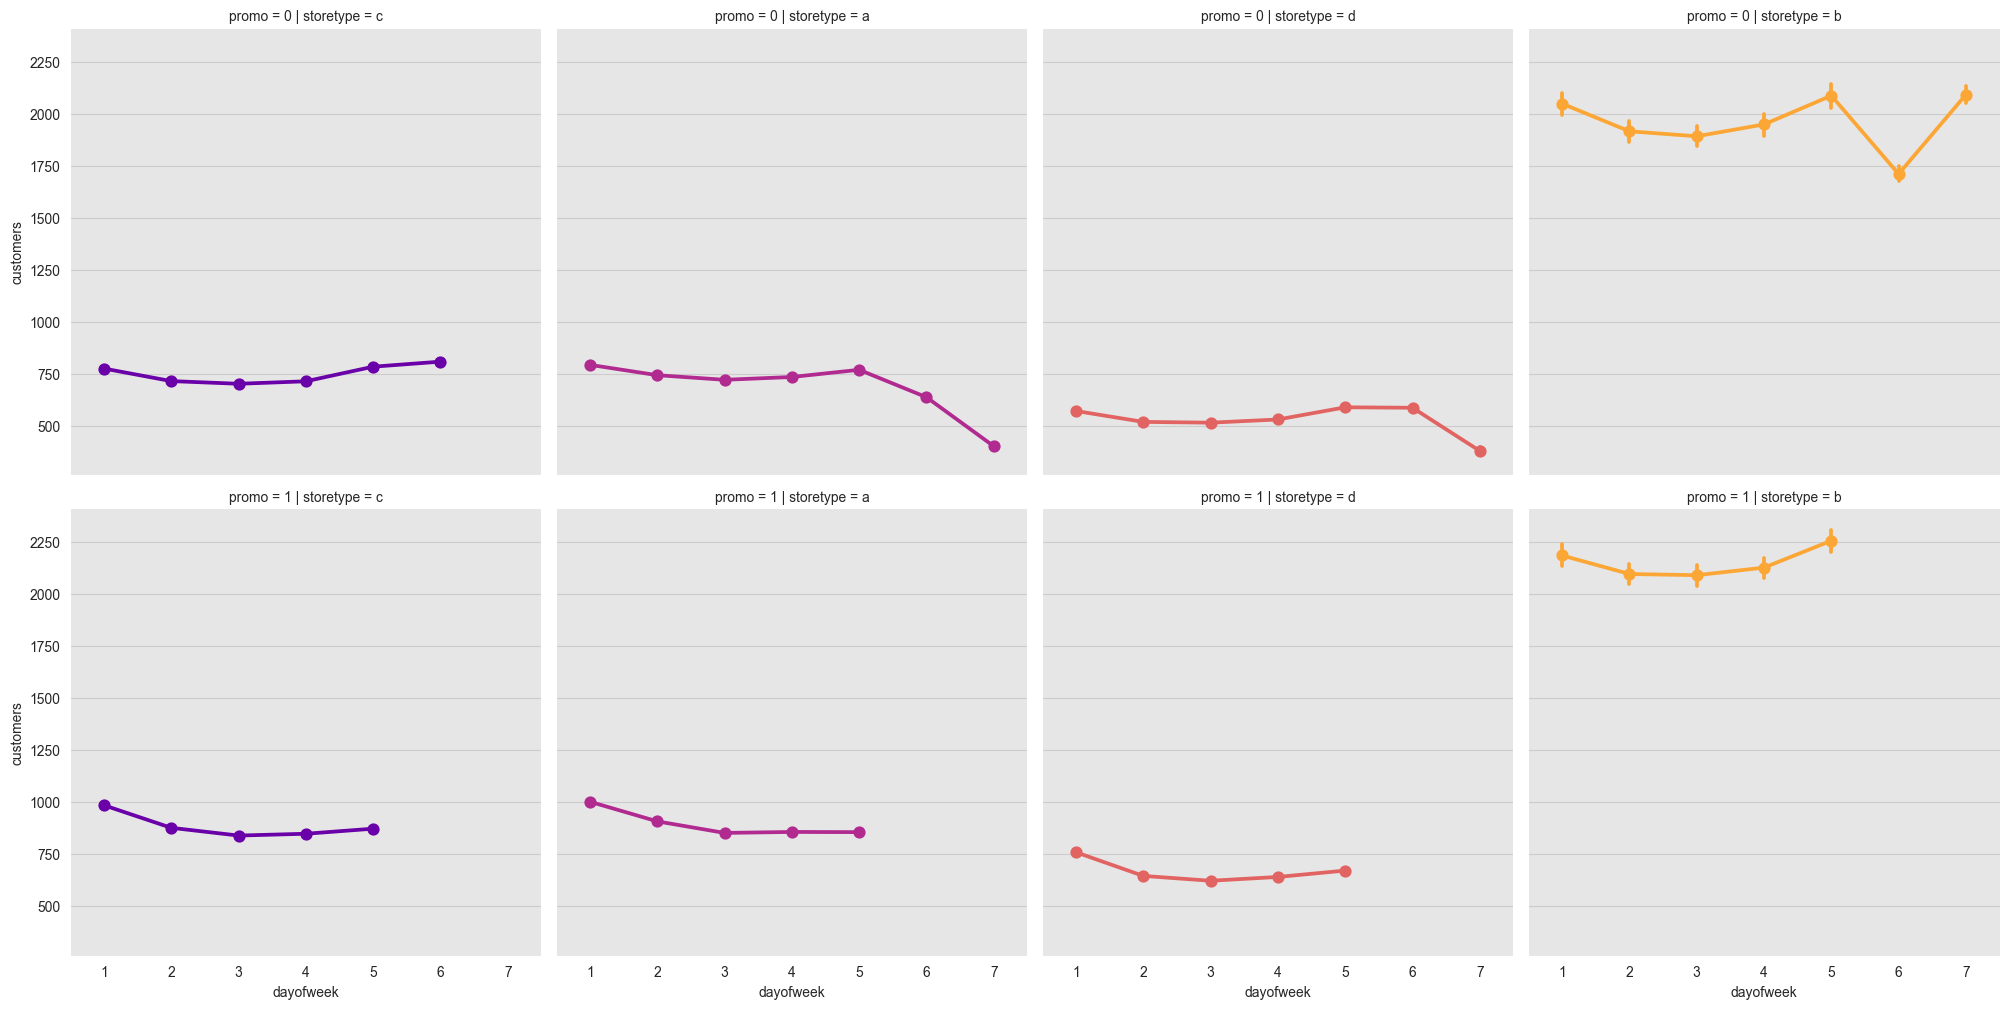

In [120]:
# weekday customer trends
sns.factorplot(data = df, x = 'dayofweek', y = "customers", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo',
               ) 

Promos are run only during the work-week, no promo on saturday/sunday.

Storetype b also open on sundays -> trainstation, fo sho
storetyp a lower number of customers on saturday, c and d increased

### Conclusion:
- Promos are run only during the work-week, no promo on saturday/sunday\n",
- Storetype B has the highest number of customers, with the largest variance\n",
- Storetype B has the highest sales numbers, with the largest variance\n",
- All storetypes show increased sales numbers towards christmas\n",
- Stores which have run a promo, show higher sales. But storetypes a, c and d show a dip towards easter, if they have run a promo, which is not the case for stores without a promo."

In [121]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
store,844338.0,558.42,321.73,1.00,280.0,558.00,837.0,1115.00
dayofweek,844338.0,3.52,1.72,1.00,2.0,3.00,5.0,7.00
sales,844338.0,6955.96,3103.82,46.00,4859.0,6369.00,8360.0,41551.00
customers,844338.0,762.78,401.19,8.00,519.0,676.00,893.0,7388.00
open,844338.0,1.00,0.00,1.00,1.0,1.00,1.0,1.00
promo,844338.0,0.45,0.50,0.00,0.0,0.00,1.0,1.00
schoolholiday,844338.0,0.19,0.40,0.00,0.0,0.00,0.0,1.00
year,844338.0,2013.83,0.78,2013.00,2013.0,2014.00,2014.0,2015.00
month,844338.0,5.85,3.32,1.00,3.0,6.00,8.0,12.00
day,844338.0,15.84,8.68,1.00,8.0,16.00,23.0,31.00


<AxesSubplot:>

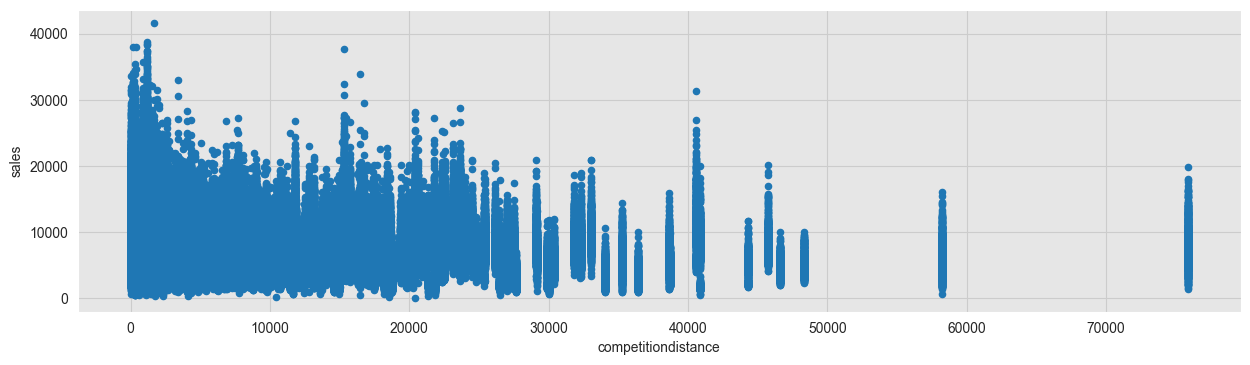

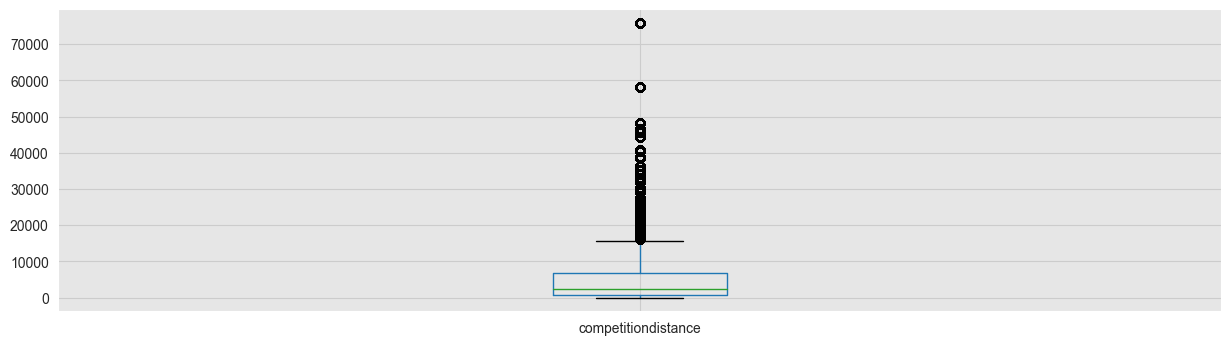

In [122]:
# Plot CompetitionDistance Vs Sales
df.plot(kind='scatter',x='competitiondistance',y='sales', figsize=(15,4))
df.plot(kind='box', y='competitiondistance', figsize=(15,4))

75% of all stores have their nearest competitor at under 7km distance, while 50% of all stores have their nearest competitor at 2.3km.

<AxesSubplot:xlabel='storetype', ylabel='competitiondistance'>

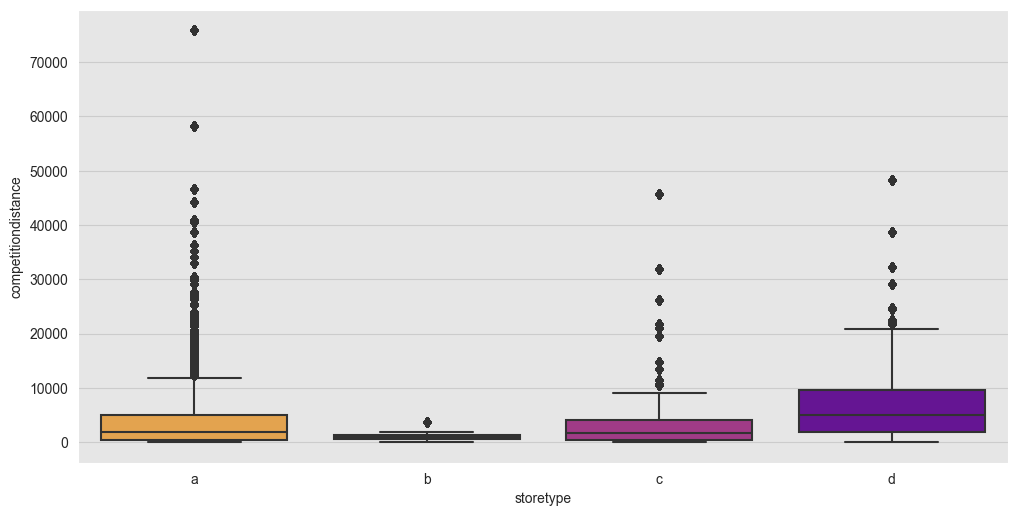

In [123]:
sns.boxplot(data= df, x= 'storetype', y= 'competitiondistance', palette = 'plasma_r', order=["a", "b", "c", "d"])

Storetype B has the nearest competitors, while storetyp D has the largest range and the largest mean distance. The farthest away competitors belong to Storetype A.

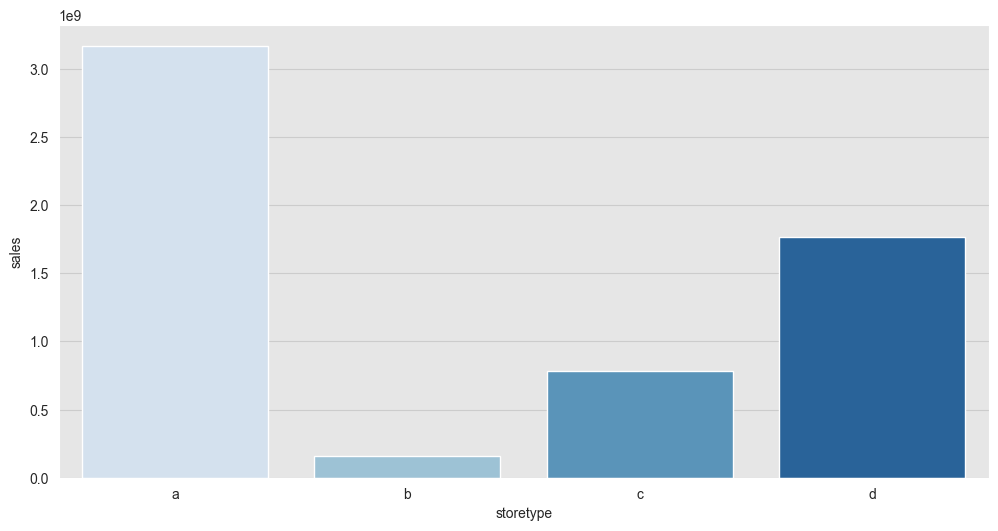

In [124]:
temp_df = df.groupby(df.storetype).sum()
sns.barplot(temp_df.index, temp_df.sales, palette='Blues');

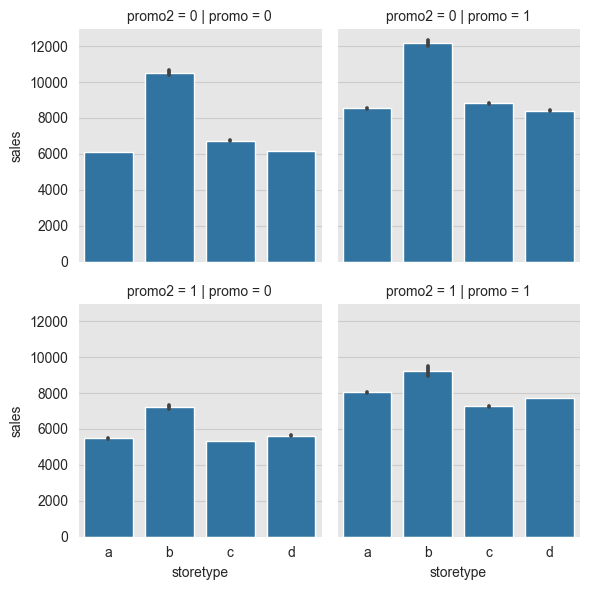

In [125]:
# plotting sales per storetype, based on promo1 or promo2
g = sns.FacetGrid(data = df,
                  col = 'promo',
                  row = 'promo2',
                  palette = 'plasma',
                  #hue = 'assortment',
                 )
g.map_dataframe(sns.barplot, "storetype", "sales", order=["a","b","c","d"])

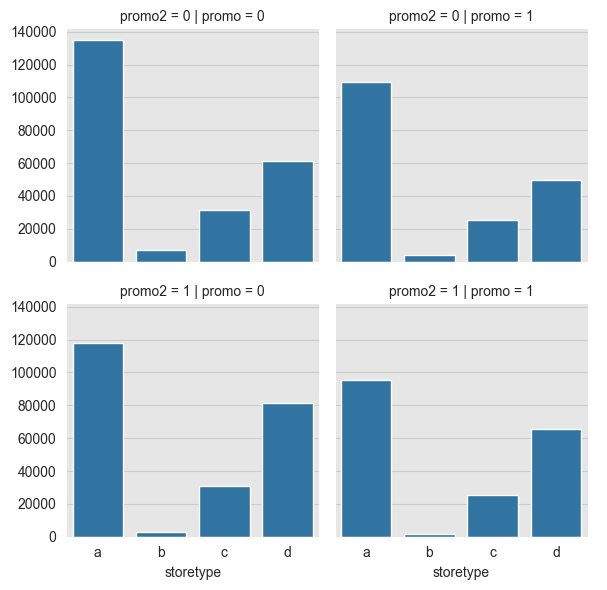

In [126]:
# plotting counts per storetype, based on promo1 or promo2
g = sns.FacetGrid(data = df, 
               col = 'promo',
                  row = 'promo2',
               palette = 'plasma',
               #hue = 'assortment',
               )
g.map_dataframe(sns.countplot, "storetype", order=["a","b","c","d"])
g.add_legend()

### Datatype and Encoding of Features

# Time Series Analysis

Plotting the seasonal decomposition of the sales per date. For this, the data for each day will be summed up and grouped by.

Afterwards, the model will decompose the sale values in an additive manner.

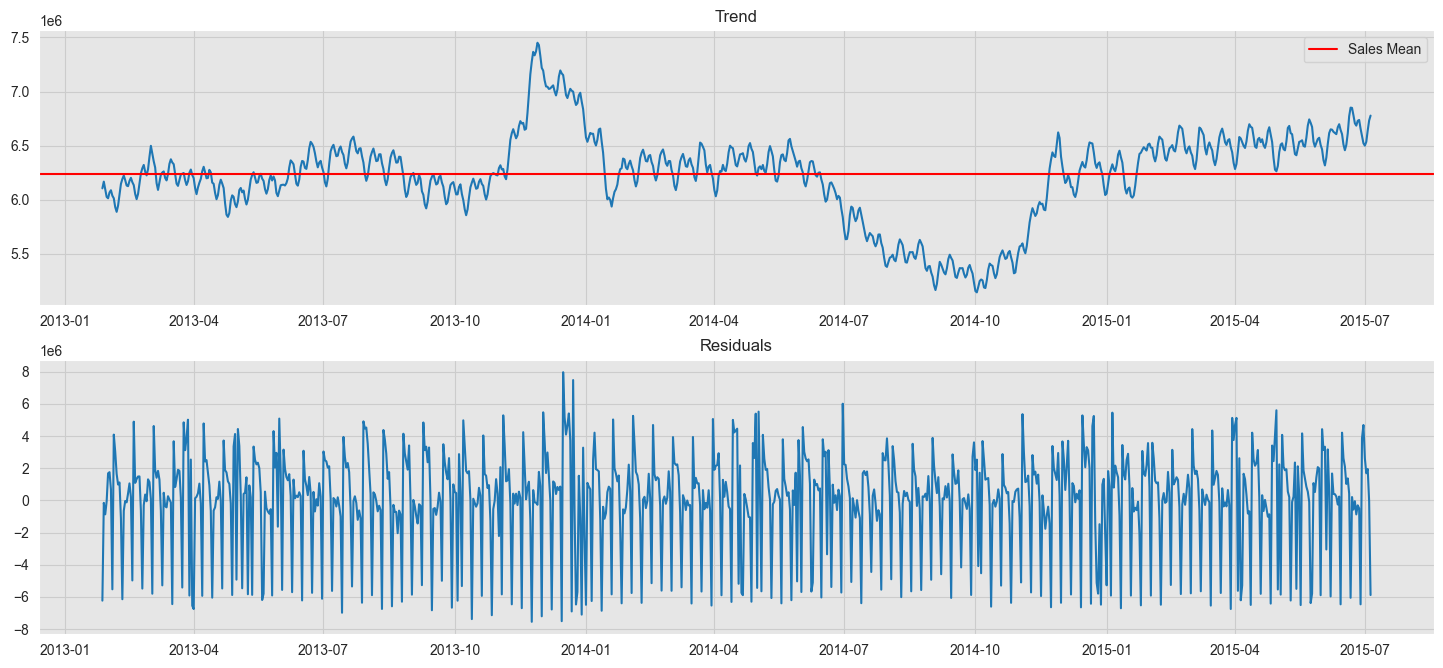

In [127]:
tmp_df = df.groupby(df['timestamp']).sum()
season_decomp = seasonal_decompose(tmp_df['sales'], model='additive', freq=52)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,8))
ax1.plot(season_decomp.trend)
ax1.axhline(y = tmp_df['sales'].mean(), color = 'r', linestyle = '-', label='Sales Mean')
ax1.set_title("Trend")
ax2.plot(season_decomp.resid)
ax2.set_title("Residuals")
ax1.legend()
plt.show()

The beginning of 2014 and 2015 show higher than average sales numbers. Especially the peak at the beginning of 2014 is very high.

During the second half of 2014, the sales drop significantly under the average value.

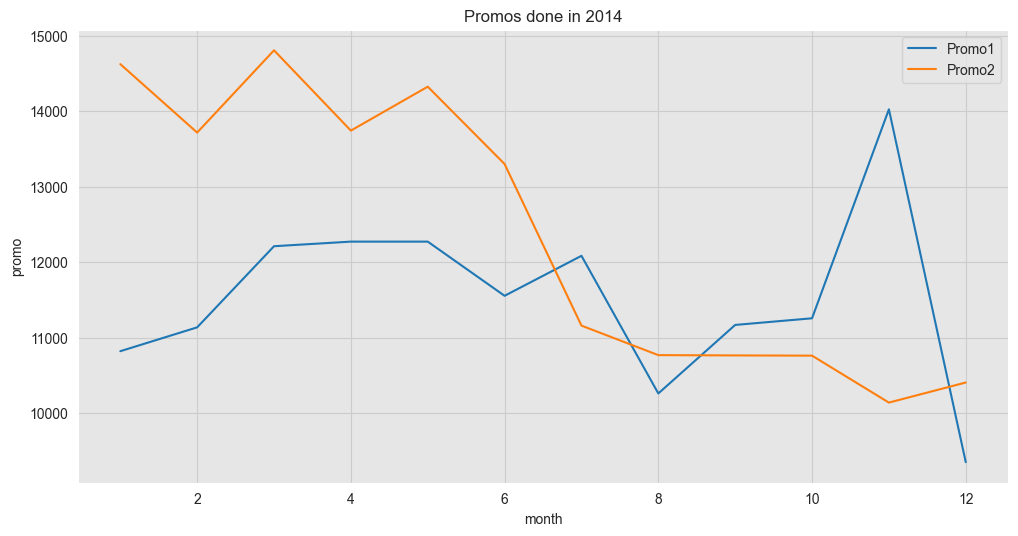

In [128]:
tmp_df = df.copy()
tmp_df = tmp_df[tmp_df['year']==2014]
tmp_df = tmp_df.groupby(tmp_df['month']).sum()

plt.title('Promos done in 2014')
sns.lineplot(data=tmp_df, x=tmp_df.index, y=tmp_df['promo'], palette='Blues', label='Promo1')
sns.lineplot(data=tmp_df, x=tmp_df.index, y=tmp_df['promo2'], palette='Blues', label='Promo2')
plt.legend()
plt.show()

The downwards trend of sales at the second half of 2014 until Christmas time seems to coincide with the decreasing number of promos during that period.

In [129]:
tmp_df = df.groupby(df['timestamp']).sum()

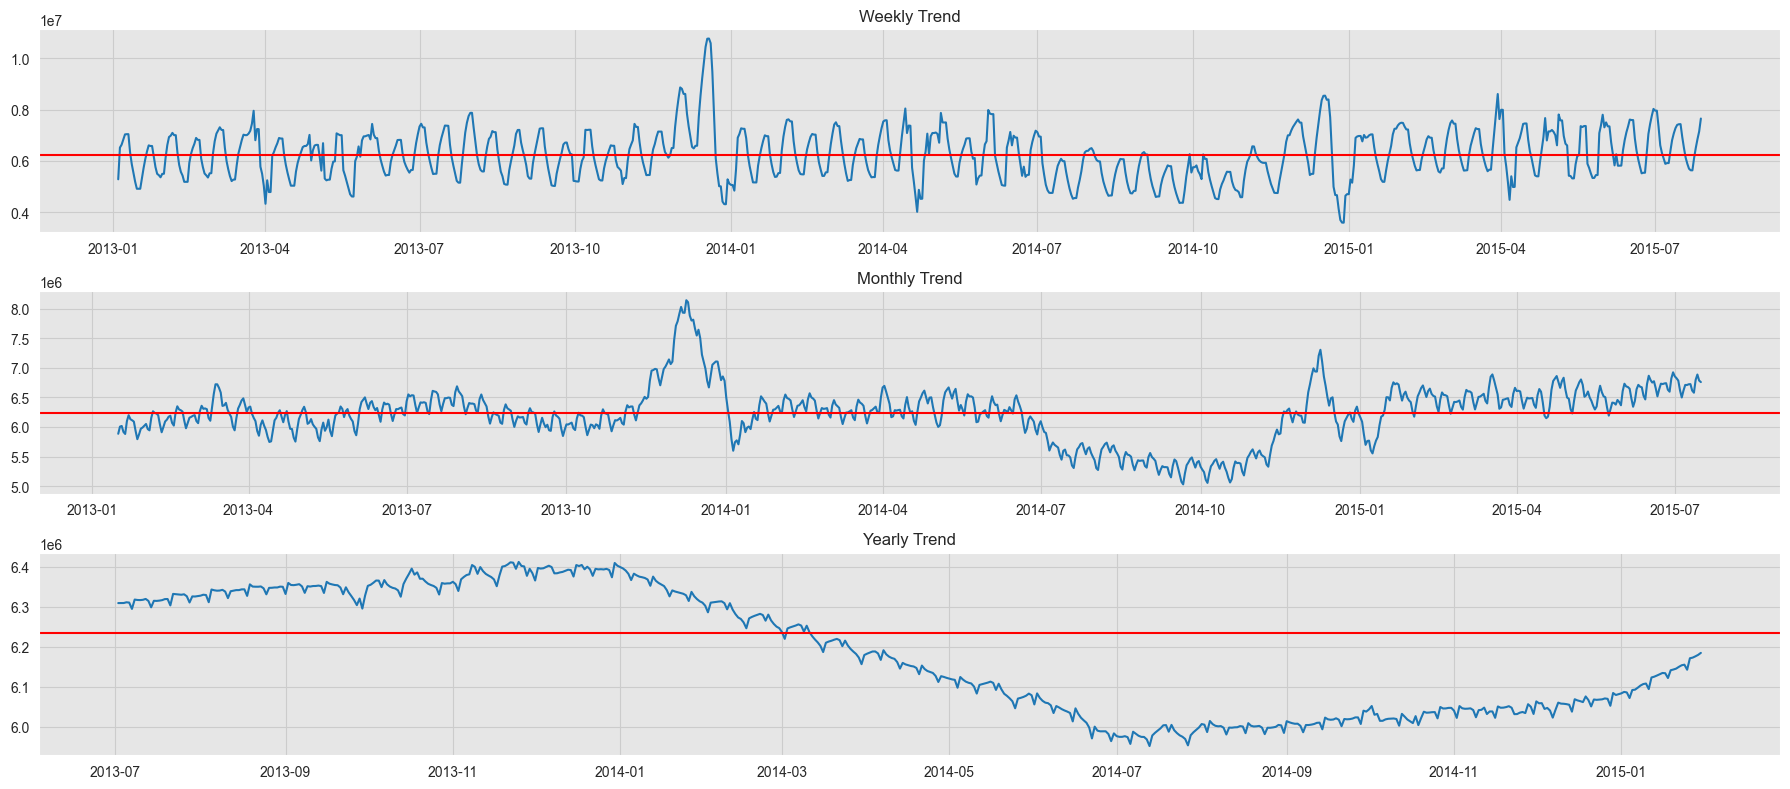

In [130]:
#freq = 7(weekly), 30(monthly), 365(yearly)
weekly_decomp = seasonal_decompose(tmp_df['sales'], model='additive', freq=7)
monthly_decomp = seasonal_decompose(tmp_df['sales'], model='additive', freq=30)
yearly_decomp = seasonal_decompose(tmp_df['sales'], model='additive', freq=365)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(18,8))
ax1.plot(weekly_decomp.trend)
ax1.axhline(y = tmp_df['sales'].mean(), color = 'r', linestyle = '-', label='Sales Mean')
ax1.set_title("Weekly Trend")
ax2.plot(monthly_decomp.trend)
ax2.axhline(y = tmp_df['sales'].mean(), color = 'r', linestyle = '-', label='Sales Mean')
ax2.set_title("Monthly Trend")
ax3.plot(yearly_decomp.trend)
ax3.axhline(y = tmp_df['sales'].mean(), color = 'r', linestyle = '-', label='Sales Mean')
ax3.set_title("Yearly Trend")
fig.tight_layout() 
plt.show()

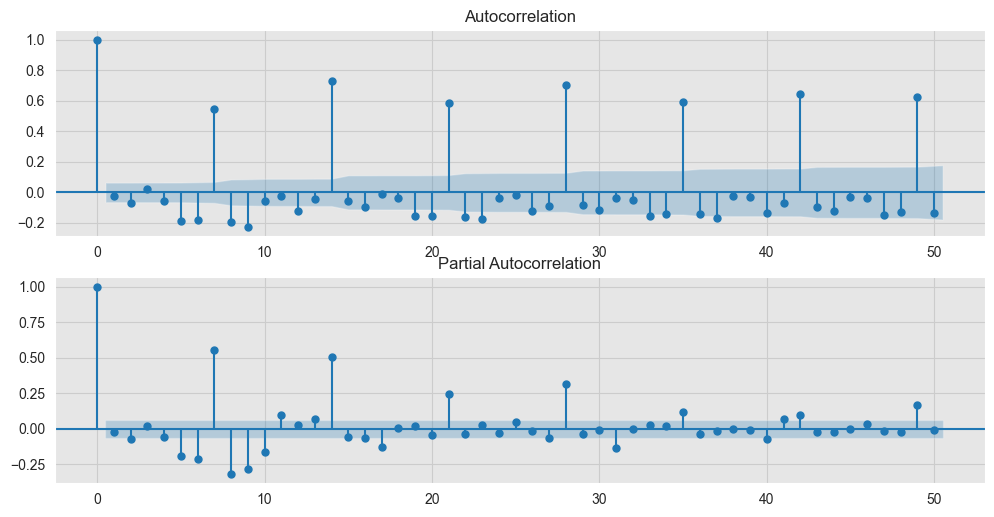

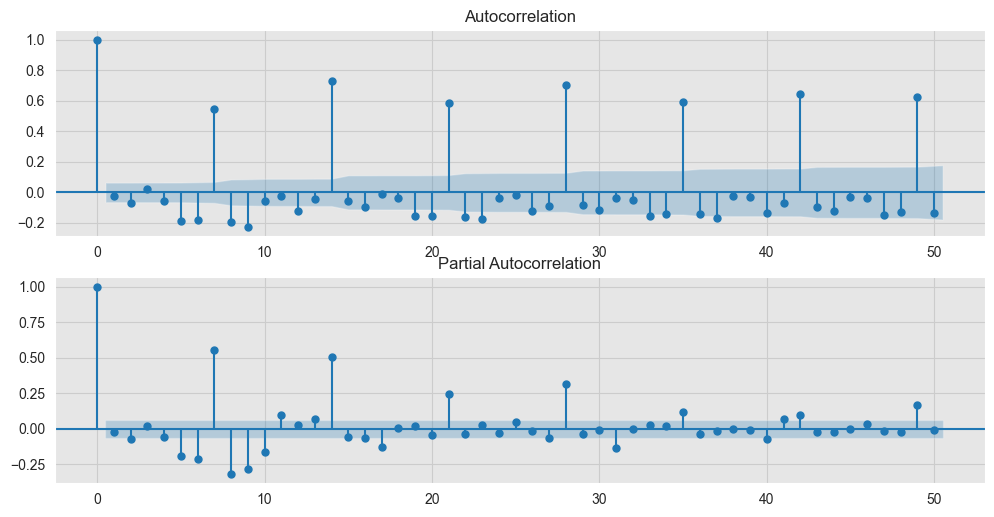

In [131]:
# Plot autocorrelation
f, (ax1, ax2) = plt.subplots(2, figsize = (12, 6))
plot_acf(tmp_df['sales'], lags = 50, ax=ax1)
plot_pacf(tmp_df['sales'], lags = 50, ax=ax2)

Those plots are showing the correlation of the series with itself, lagged by x time units correlation of the series with itself, lagged by x time units.

There is at two things common: non randomnes of the time series and high lag-1 (which will probably need a higher order of differencing d/D).

There is a weekly trend with positives spikes at the 7(s), 14(2s), 21(3s) and 28(4s) lags.


# Feature Engineering

In this section, varios categorical features will be either one-hot encoded(nominal feature) or label encoded (ordinal data). In addition, features regarding holiday and promo intervals will also be added.

In [132]:
print(df.shape)
df.head()

(844338, 23)


,store,dayofweek,sales,customers,open,promo,stateholiday,schoolholiday,timestamp,year,...,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,promointerval,salepercustomer
0,1,5,5263,555,1,1,0,1,2015-07-31,2015,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,9.482883
1,2,5,6064,625,1,1,0,1,2015-07-31,2015,...,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",9.702400
2,3,5,8314,821,1,1,0,1,2015-07-31,2015,...,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",10.126675
3,4,5,13995,1498,1,1,0,1,2015-07-31,2015,...,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,9.342457
4,5,5,4822,559,1,1,0,1,2015-07-31,2015,...,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,8.626118


First, the test data-set needs to be cleaned and features converted

In [133]:
# changing date into datetime object, inserting year, month, day and dayofyear columns
df_test = df_test.assign(
            timestamp = lambda x: pd.to_datetime(x['date']),
            year = lambda x: x['timestamp'].dt.year,
            month = lambda x: x['timestamp'].dt.month,
            day = lambda x: x['timestamp'].dt.day,
            dayofyear = lambda x: x['timestamp'].dt.dayofyear)
df_test.drop("date", inplace=True, axis=1)

In [134]:
# check for correct assignment of 'stateholiday' values
print(df_test['stateholiday'].unique())
print(df_test['stateholiday'].value_counts())

['0' 'a']
0    40908
a      180
Name: stateholiday, dtype: int64


In [135]:
# check for closed stores
df_test[df_test["open"].isnull()]

,id,store,dayofweek,open,promo,stateholiday,schoolholiday,timestamp,year,month,day,dayofyear
479,480,622,4,NaN,1,0,0,2015-09-17,2015,9,17,260
1335,1336,622,3,NaN,1,0,0,2015-09-16,2015,9,16,259
2191,2192,622,2,NaN,1,0,0,2015-09-15,2015,9,15,258
3047,3048,622,1,NaN,1,0,0,2015-09-14,2015,9,14,257
4759,4760,622,6,NaN,0,0,0,2015-09-12,2015,9,12,255
5615,5616,622,5,NaN,0,0,0,2015-09-11,2015,9,11,254
6471,6472,622,4,NaN,0,0,0,2015-09-10,2015,9,10,253
7327,7328,622,3,NaN,0,0,0,2015-09-09,2015,9,9,252
8183,8184,622,2,NaN,0,0,0,2015-09-08,2015,9,8,251
9039,9040,622,1,NaN,0,0,0,2015-09-07,2015,9,7,250


All of these store have no information for 'open', although these days are not a holiday ('stateholiday =/= 1) and are not affected by the closure of schools. They should be open.

In [136]:
df_test['open'].fillna(1, inplace=True)
df_test['open']= df_test['open'].astype(int)

In [137]:
df_test.isnull().sum()

id               0
store            0
dayofweek        0
open             0
promo            0
stateholiday     0
schoolholiday    0
timestamp        0
year             0
month            0
day              0
dayofyear        0
dtype: int64

In [138]:
df_train['is_train'] = 1
df_test['is_train'] = 0

In [139]:
print(df_train.columns)
print('-----------------')
print(df_test.columns)
print('-----------------')
print(df_store.columns)

Index(['store', 'dayofweek', 'sales', 'customers', 'open', 'promo',
       'stateholiday', 'schoolholiday', 'timestamp', 'year', 'month', 'day',
       'dayofyear', 'is_train'],
      dtype='object')
-----------------
Index(['id', 'store', 'dayofweek', 'open', 'promo', 'stateholiday',
       'schoolholiday', 'timestamp', 'year', 'month', 'day', 'dayofyear',
       'is_train'],
      dtype='object')
-----------------
Index(['store', 'storetype', 'assortment', 'competitiondistance',
       'competitionopensincemonth', 'competitionopensinceyear', 'promo2',
       'promo2sinceweek', 'promo2sinceyear', 'promointerval'],
      dtype='object')


In [140]:
df_model = pd.concat([df_train, df_test])

In [141]:
df_model.head()

,store,dayofweek,sales,customers,open,promo,stateholiday,schoolholiday,timestamp,year,month,day,dayofyear,is_train,id
0,1,5,5263.0,555.0,1,1,0,1,2015-07-31,2015,7,31,212,1,NaN
1,2,5,6064.0,625.0,1,1,0,1,2015-07-31,2015,7,31,212,1,NaN
2,3,5,8314.0,821.0,1,1,0,1,2015-07-31,2015,7,31,212,1,NaN
3,4,5,13995.0,1498.0,1,1,0,1,2015-07-31,2015,7,31,212,1,NaN
4,5,5,4822.0,559.0,1,1,0,1,2015-07-31,2015,7,31,212,1,NaN


### Feature engineering from store features

In [142]:
features_x = ['store', 'timestamp', 'dayofweek', 'open', 'promo', 'schoolholiday', 'stateholiday']
features_y = ['saleslog']

In [143]:
# encoding categorical features
df_model['stateholiday'] = LabelEncoder().fit_transform(df_model['stateholiday']) 
df_store['storetype'] = LabelEncoder().fit_transform(df_store['storetype'])
df_store['assortment'] = LabelEncoder().fit_transform(df_store['assortment'])

Promo interval feature engineering

In [144]:
# splitting 'Promointerval' string into individual strings and get the month
prom_interval = df_store['promointerval'].str.split(',').apply(pd.Series)

In [145]:
prom_interval.columns = prom_interval.columns.map(lambda x: str(x) + '_prominterval')
df_store = df_store.join(prom_interval)

In [146]:
def monthToNum(value):
    if(value=='Sept'):
        value='Sep'
    return list(calendar.month_abbr).index(value)
#mapping month abbr to month number
df_store['0_prominterval'] = df_store['0_prominterval'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
df_store['1_prominterval'] = df_store['1_prominterval'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
df_store['2_prominterval'] = df_store['2_prominterval'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
df_store['3_prominterval'] = df_store['3_prominterval'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)

Promo feature engineering

In [147]:
promo = []
for index, value in df_store[['promo2sinceweek', 'promo2sinceyear']].iterrows():
    try:
        year, week = int(value['promo2sinceyear']), int(value['promo2sinceweek'])
        date = pd.to_datetime("{}-{}-01".format(year, week), format='%Y%W')
        promo.append(date)
    except:
        promo.append(np.nan)
promo = pd.to_datetime(pd.Series(promo))
promo.shape

(1115,)

In [148]:
df_store['promosince'] = promo #converted int to datetime
df_store['promosince'] = df_store.promosince.dt.strftime('%Y%m%d')

Competition feature engineering

In [149]:
competition_open = []
for index, value in df_store[['competitionopensincemonth', 'competitionopensinceyear']].iterrows():
    try:
        year, month = int(value['competitionopensinceyear']), int(value['competitionopensincemonth'])
        date = pd.to_datetime("{}-{}-01".format(year, month), format='%Y-%m')
        competition_open.append(date)
    except:
        competition_open.append(np.nan)
competition_open = pd.Series(competition_open)
competition_open.shape

(1115,)

In [150]:
df_store['competitionopen'] = competition_open #converted int to datetime
df_store['competitionopen'] = df_store['competitionopen'].dt.strftime('%Y%m%d')

This concludes the feature engineering from df_store.
The newly created features are put into store_features

In [151]:
store_features = ['store', 'storetype', 'assortment', 'competitiondistance', 'competitionopen', 
                  'promosince', '0_prominterval']

In [152]:
df_model = pd.merge(df_model, df_store[store_features], how='left', on=['store'])

In [153]:
# put new features into feature-list
features_x = list(set(features_x + store_features))

for feature in features_x:
    df_model[feature] = df_model[feature].fillna(-999) #out of range value for model

In [154]:
df_model['dateint'] = df_model.timestamp.dt.strftime('%Y%m%d').map(int) #mapping to Int
df_model['competitionopen'] = df_model.competitionopen.map(int)
df_model['promosince'] = df_model.promosince.map(int)

### Feature engineering from df_train features

Promo feature engineering

In [155]:
df_model['promotomorrow'] = df_model.promo.shift(-1)
df_model['promoyesterday'] = df_model.promo.shift(1)

In [156]:
promo_features = ['promotomorrow', 'promoyesterday']

features_x = list(set(features_x + promo_features))

Store sales and customers feature engineering

In [157]:
store_data_sales = df_model.groupby([df_model['store']])['sales'].sum()
store_data_customers = df_model.groupby([df_model['store']])['customers'].sum()
store_data_open = df_model.groupby([df_model['store']])['open'].count()

store_data_sales_per_day = store_data_sales / store_data_open
store_data_customers_per_day = store_data_customers / store_data_open
store_data_sales_per_customer_per_day = store_data_sales_per_day / store_data_customers_per_day

df_sales_cust = pd.merge(df_store, store_data_sales_per_day.reset_index(name='salesperday'), how='left', on=['store'])
df_sales_cust = pd.merge(df_sales_cust, store_data_customers_per_day.reset_index(name='customersperday'), how='left', on=['store'])
df_sales_cust = pd.merge(df_sales_cust, store_data_sales_per_customer_per_day.reset_index(name='salespercustomersperday'), how='left', on=['store'])

In [158]:
store_features = ['store', 'salesperday', 'customersperday', 'salespercustomersperday']

features_x = list(set(features_x + store_features))
df_model = pd.merge(df_model, df_sales_cust[store_features], how='left', on=['store'])

Holiday feature engineering

In [159]:
holidays_next_week=[]
holidays_next_week_index=[]
for index, value in df_model.groupby(df_model['timestamp']).sum().iterrows():
    start_range = index + datetime.timedelta(days=7)
    end_range = index + datetime.timedelta(days=15)
    school_holidays = sum((df_model.groupby(df_model['timestamp']).sum()[start_range:end_range]).schoolholiday)
    state_holidays = sum((df_model.groupby(df_model['timestamp']).sum()[start_range:end_range]).stateholiday)
    holidays_next_week.append(school_holidays+state_holidays)
    holidays_next_week_index.append(index)
    
holidays_next_week = pd.Series(holidays_next_week)
holidays_next_week.shape

(990,)

In [160]:
holidays_this_week=[]
index_list = []
for index, value in df_model.groupby(df_model['timestamp']).sum().iterrows():
    start_range = index 
    end_range = index + datetime.timedelta(days=7)
    school_holidays = sum((df_model.groupby(df_model['timestamp']).sum()[start_range:end_range]).schoolholiday)
    state_holidays = sum((df_model.groupby(df_model['timestamp']).sum()[start_range:end_range]).stateholiday)
    holidays_this_week.append(school_holidays+state_holidays)
    index_list.append(index)
    
holidays_this_week = pd.Series(holidays_this_week)
holidays_this_week.shape

(990,)

In [161]:
holidays_last_week=[]
holidays_last_week_index=[]
for index, value in df_model.groupby(df_model['timestamp']).sum().iterrows():
    start_range = index - datetime.timedelta(days=7)
    end_range = index + datetime.timedelta(days=1)
    school_holidays = sum((df_model.groupby(df_model['timestamp']).sum()[start_range:end_range]).schoolholiday)
    state_holidays = sum((df_model.groupby(df_model['timestamp']).sum()[start_range:end_range]).stateholiday)
    holidays_last_week.append(school_holidays+state_holidays)
    holidays_last_week_index.append(index)
    
holidays_last_week = pd.Series(holidays_next_week)
holidays_last_week.shape

(990,)

In [162]:
temp_df = pd.DataFrame({'holidaysnextweek':holidays_next_week, 'timestamp': holidays_next_week_index})
df_model = pd.merge(df_model, temp_df, on=['timestamp'])

In [163]:
temp_df = pd.DataFrame({'holidaysthisweek':holidays_this_week, 'timestamp': index_list})
df_model = pd.merge(df_model, temp_df, on=['timestamp'])

In [164]:
temp_df = pd.DataFrame({'holidayslastweek':holidays_last_week, 'timestamp': holidays_last_week_index})
df_model = pd.merge(df_model, temp_df, on=['timestamp'])

In [165]:
holidays_features = ['holidaysnextweek', 'holidaysthisweek', 'holidayslastweek']

features_x = list(set(features_x + holidays_features))

In [166]:
print(df_model.shape)
df_model.head()

(885426, 30)


,store,dayofweek,sales,customers,open,promo,stateholiday,schoolholiday,timestamp,year,...,0_prominterval,dateint,promotomorrow,promoyesterday,salesperday,customersperday,salespercustomersperday,holidaysnextweek,holidaysthisweek,holidayslastweek
0,1,5,5263.0,555.0,1,1,0,1,2015-07-31,2015,...,-999.0,20150731,1.0,NaN,4483.539204,531.390832,8.437366,4860,5481,4860
1,2,5,6064.0,625.0,1,1,0,1,2015-07-31,2015,...,1.0,20150731,1.0,1.0,4953.900510,583.998724,8.482725,4860,5481,4860
2,3,5,8314.0,821.0,1,1,0,1,2015-07-31,2015,...,1.0,20150731,1.0,1.0,6539.614268,706.541717,9.255808,4860,5481,4860
3,4,5,13995.0,1498.0,1,1,0,1,2015-07-31,2015,...,-999.0,20150731,1.0,1.0,9638.401786,1321.752551,7.292138,4860,5481,4860
4,5,5,4822.0,559.0,1,1,0,1,2015-07-31,2015,...,-999.0,20150731,1.0,1.0,4676.274711,537.340180,8.702634,4860,5481,4860


In [167]:
print(df_model.columns)
print(features_x)

Index(['store', 'dayofweek', 'sales', 'customers', 'open', 'promo',
       'stateholiday', 'schoolholiday', 'timestamp', 'year', 'month', 'day',
       'dayofyear', 'is_train', 'id', 'storetype', 'assortment',
       'competitiondistance', 'competitionopen', 'promosince',
       '0_prominterval', 'dateint', 'promotomorrow', 'promoyesterday',
       'salesperday', 'customersperday', 'salespercustomersperday',
       'holidaysnextweek', 'holidaysthisweek', 'holidayslastweek'],
      dtype='object')
['promoyesterday', 'dayofweek', 'holidaysnextweek', 'open', 'holidayslastweek', '0_prominterval', 'promosince', 'timestamp', 'salesperday', 'promo', 'promotomorrow', 'competitionopen', 'salespercustomersperday', 'holidaysthisweek', 'storetype', 'schoolholiday', 'assortment', 'store', 'competitiondistance', 'stateholiday', 'customersperday']


In [168]:
features_x = ['store', 'dayofweek', 'open', 'promo',
       'stateholiday', 'schoolholiday', 'year', 'month', 'day',
       'dayofyear', 'storetype', 'assortment',
       'competitiondistance', 'competitionopen', 'promosince',
       '0_prominterval', 'dateint', 'promotomorrow', 'promoyesterday',
       'salesperday', 'customersperday', 'salespercustomersperday',
       'holidaysnextweek', 'holidaysthisweek', 'holidayslastweek']

# Predictive modelling

## XGBoost

For XGBoost and the RMSPE evaluation, no 0 values are permitted

In [169]:
checkpoint = df_model.copy()

In [170]:
df_model.sales = df_model.sales.apply(lambda x: np.nan if x == 0 else x)
df_model.loc[df_model['is_train'] == 1, 'saleslog'] = np.log(1+df_model.loc[df_model['is_train'] == 1]['sales'])

In [171]:
#train test split
data = df_model.loc[(df_model['is_train'] == 1)]
x_train, x_test, y_train, y_test = train_test_split(data[features_x], 
                                                    data[features_y], 
                                                    test_size=0.2, 
                                                    random_state=3)

In [172]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(675470, 25) (675470, 1) (168868, 25) (168868, 1)


In [173]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

num_round = 20000
evallist = [(dtrain, 'train'), (dtest, 'test')]





In [174]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.03,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 10
          }

pslst = list(params.items())

param = {'max_depth': 9,
         'eta': 0.01,
         'subsample': 0.75,
         'colsample_bytree': 0.6, 
         'objective': 'reg:squarederror',}

plst = list(param.items())

In [175]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [176]:
model = xgb.train(plst, dtrain, num_round, evallist,
                  feval=rmspe_xg, verbose_eval=250, early_stopping_rounds=100)

[0]	train-rmse:8.18569	train-rmspe:0.99986	test-rmse:8.18794	test-rmspe:0.99986
[250]	train-rmse:0.68375	train-rmspe:0.49432	test-rmse:0.68444	test-rmspe:0.48742
[500]	train-rmse:0.14622	train-rmspe:0.19593	test-rmse:0.14756	test-rmspe:0.15153
[750]	train-rmse:0.12445	train-rmspe:0.17672	test-rmse:0.12657	test-rmspe:0.14021
[1000]	train-rmse:0.11770	train-rmspe:0.16653	test-rmse:0.12044	test-rmspe:0.13424
[1250]	train-rmse:0.11261	train-rmspe:0.15789	test-rmse:0.11595	test-rmspe:0.12943
[1500]	train-rmse:0.10870	train-rmspe:0.15082	test-rmse:0.11262	test-rmspe:0.12592
[1750]	train-rmse:0.10535	train-rmspe:0.14547	test-rmse:0.10984	test-rmspe:0.12310
[2000]	train-rmse:0.10237	train-rmspe:0.13894	test-rmse:0.10739	test-rmspe:0.12068
[2250]	train-rmse:0.10002	train-rmspe:0.13452	test-rmse:0.10554	test-rmspe:0.11877
[2500]	train-rmse:0.09789	train-rmspe:0.12831	test-rmse:0.10392	test-rmspe:0.11725
[2750]	train-rmse:0.09567	train-rmspe:0.12387	test-rmse:0.10222	test-rmspe:0.11564
[3000]	tra

In [177]:
#make a submission dataframe to test RMSPE for unseen test-data (test.csv)
submit = df_model.loc[df_model['is_train'] == 0]
dsubmit = xgb.DMatrix(submit[features_x])
predictions = model.predict(dsubmit)

df_predictions = submit['id'].reset_index()
df_predictions['Id'] = df_predictions['id'].astype('int')
df_predictions['Sales'] = (np.exp(predictions) - 1) * 0.985 #Scale Back

df_predictions.sort_values('Id', inplace=True)
df_predictions[['Id', 'Sales']].to_csv('submit_xgboost_03.csv', index=False)

<Figure size 1800x800 with 0 Axes>

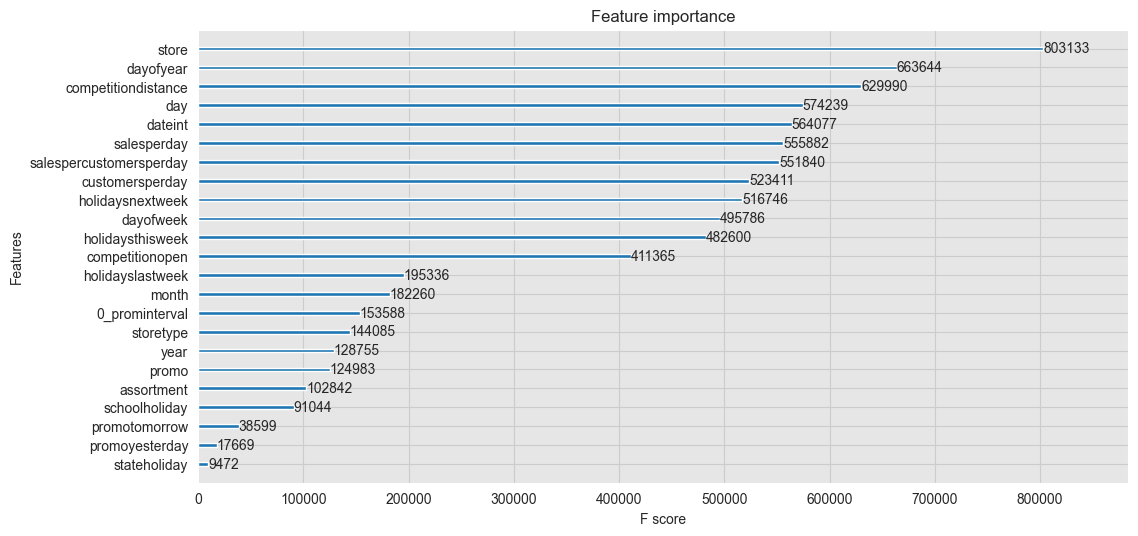

<Figure size 1200x600 with 0 Axes>

In [178]:
#Print Feature Importance
plt.figure(figsize=(18,8))
from xgboost import plot_importance
plot_importance(model)
plt.show()
plt.savefig('xgboost_03_feature_importance.png')

In [179]:
# save dataframes on disk
df.to_csv('dataframe_raw', index=False)
df_model.to_csv('dataframe_raw_model3', index=False)
data.to_csv('dataframe_modeldata3', index=False)

In [180]:
# save model using pickle
import pickle
filename = 'model_xgboost_03.sav'
pickle.dump(model, open(filename, 'wb'))

In [181]:
# load pickled model
import pickle
#loaded_model = pickle.load(open("/Users/bur.oez/Desktop/Capstone-Project-Rossman-Sales Kopie/model_xgboost_01.sav", 'rb'))